# Практическая работа
Профессия Data Science  
Блок 7. ML в бизнесе  
MATH&ML-13. Временные ряды. Часть II  
Студент: Новиков Павел  
Курс: DSPR - 77

# Описание проекта:

Представим, что мы работаем в государственной компании, предоставляющей анализ экономической ситуации в мире по заказу государства.

Перед нами стоит задача проанализировать ВВП  страны Гана.  <img align="right" width="330" height="180" src = https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/Flag_of_Ghana.svg/800px-Flag_of_Ghana.svg.png >
Для этого нам предоставили показатели ВВП Ганы за 62 года.   
Нам предстоит исследовать временной ряд, изучить его свойства, построить модели и сделать выводы по результатам.

Небольшая справка из Википедии:  

Га́на (англ. Ghana), официальное название — Респу́блика Га́на (англ. Republic of Ghana) — государство в Западной Африке.  
 Входит в Содружество наций.  
  Граничит на западе с Кот-д’Ивуаром, на северо-западе и севере — с Буркина-Фасо, на востоке — с Того.   
С юга омывается водами Гвинейского залива Атлантического океана.

 <img align="right" width="350" height="300" src = https://topwar.ru/uploads/posts/2014-06/thumbs/1403578876_karta_gana.jpg >

ВВП страны в основном зависит от экспорта золота (\~50%), нефти и нефтяных продуктов (\~25%) и какао-продуктов(~15%)
<img align="left" width="430" height="300" src = https://upload.wikimedia.org/wikipedia/commons/thumb/a/a9/Ghana_Product_Exports_%282019%29.svg/800px-Ghana_Product_Exports_%282019%29.svg.png>



In [ ]:
import pandas as pd # Библиотека для работы со структурированными данными
import numpy as np # Библиотека для работы с массивами и матрицами

# Библиотеки для визуализации
from matplotlib import pyplot
from matplotlib import pyplot as plt

# Библиотеки для работы со статистикой
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose #для построения графика сезонной декомпозиции имортируем соответвующий метод
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.api as smt
from statsmodels. stats.diagnostic import het_white #тест Уайта на гетероскедастичность

#метод для перебора параметров ARIMA
!pip install pmdarima
import pmdarima as pm

# Библиотека для работы с моделями машинного обучения
from sklearn import metrics # Библиотека для расчета метрик
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression # Библиотека для построения модели линейной регрессии

#метод для предсказания волатильности
!pip install arch
from arch import arch_model

from datetime import datetime

from warnings import filterwarnings
filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# В колабе импортируем все необходимые библиотеки
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Привязываем гуглдиск к колабу
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Загружаем файл в колаб
download = drive.CreateFile({"id": "15qVIudeeR6I-8TzugoI3gdweO8ZymuO8"})
download.GetContentFile("ghana_gdp.zip")

In [ ]:
# Прочитаем исходный файл с данными, создадим базу данных ВВП государства Гана
data = pd.read_csv("ghana_gdp.zip", parse_dates=["year"], index_col=["year" ])
# Для простоты здесь и далее считаем по умолчанию ВВП Ганы указанным в долларах США
data.rename(columns = {'GDP (current US$)':'GDP'}, inplace =True)
data.head()

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


Данных за 1961 год в базе нет, это не связано с тем, что в этот год была гиперинфляция или иной кризис, экономика работала и по данным сайта https://www.macrotrends.net/countries/GHA/ghana/gdp-gross-domestic-product ВВП за 1961 год составил \~1,330000e+09 $ USA  
Нам эти данные понадобятся, чтобы оценить как сработала функция интерполяции.  А сейчас посмотрим, нет ли ещё нулевых значений в таблице.

In [ ]:
data.sort_values(by='GDP')

,GDP
year,
1961-01-01,0.000000e+00
1960-01-01,1.217087e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1968-01-01,1.666910e+09
...,...
2013-01-01,6.282304e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


Нулевых значений кроме 1961 больше нет. Есть ли пропуски?

In [ ]:
data.isna().sum()

GDP    0
dtype: int64

Пропусков нет. Посмотрим как данные выглядят на графике

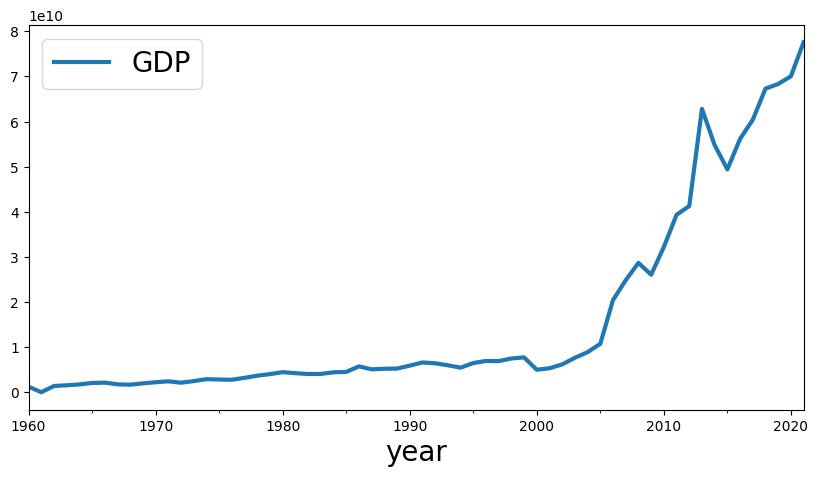

In [ ]:
# Визуализируем исходный временной ряд, построим график изменения ВВП Ганы по годам
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 5
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()

#### **Выводы**: В данном временном ряде явно присутствует тренд и отсутствует сезонность.  
***Тренд*** - основная тенденция изменения величины со временем.  
***Сезонность*** - периодические колебания ряда вдоль тренда.

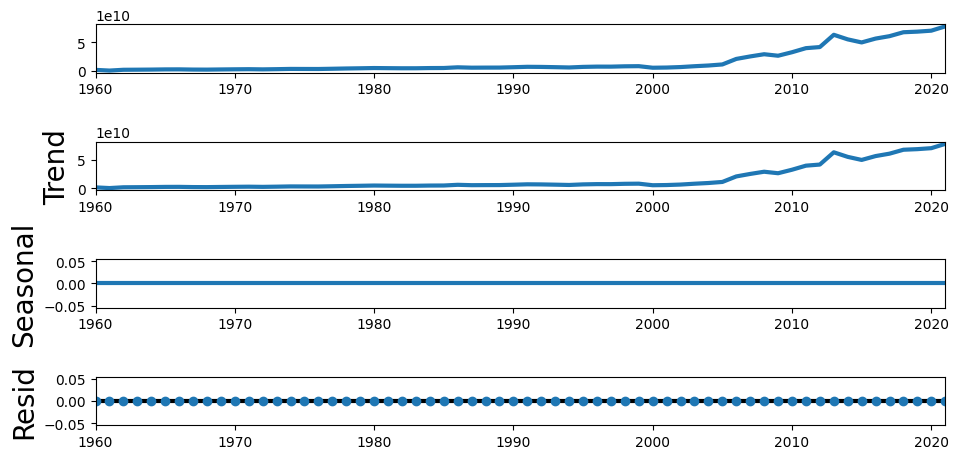

In [ ]:
# Построим график сезонной декомпозиции временного ряда

# from statsmodels.tsa.seasonal import seasonal_decompose #для построения графика сезонной декомпозиции имортируем соответствующий метод
decomposition = seasonal_decompose(data, model='additive')
decomposition.plot()
pyplot.rcParams["figure.figsize"] = 10, 10
pyplot.show()

#### **Выводы**: Построенный график декомпозиции подтверждает сделаные ранее выводы.   
Присутствует тренд, отсутствует сезонность, шум равномерно распределён в районе нуля.

In [ ]:
print(data.index.max(),' ',data.index.min())

2021-01-01 00:00:00   1960-01-01 00:00:00


In [ ]:
# Отложим последние три года из датасета, как тестовую выборку для оценки результатов предсказания.
train_df = data.loc[:"2018-01-01"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

In [ ]:
data.loc["2019-01-01":,"GDP"]

year
2019-01-01    6.833754e+10
2020-01-01    7.004320e+10
2021-01-01    7.759428e+10
Name: GDP, dtype: float64

## Модель скользящего среднего (MA)

Постройте модель скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.

Пример: train_df.spx.rolling(window=2).mean().
Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

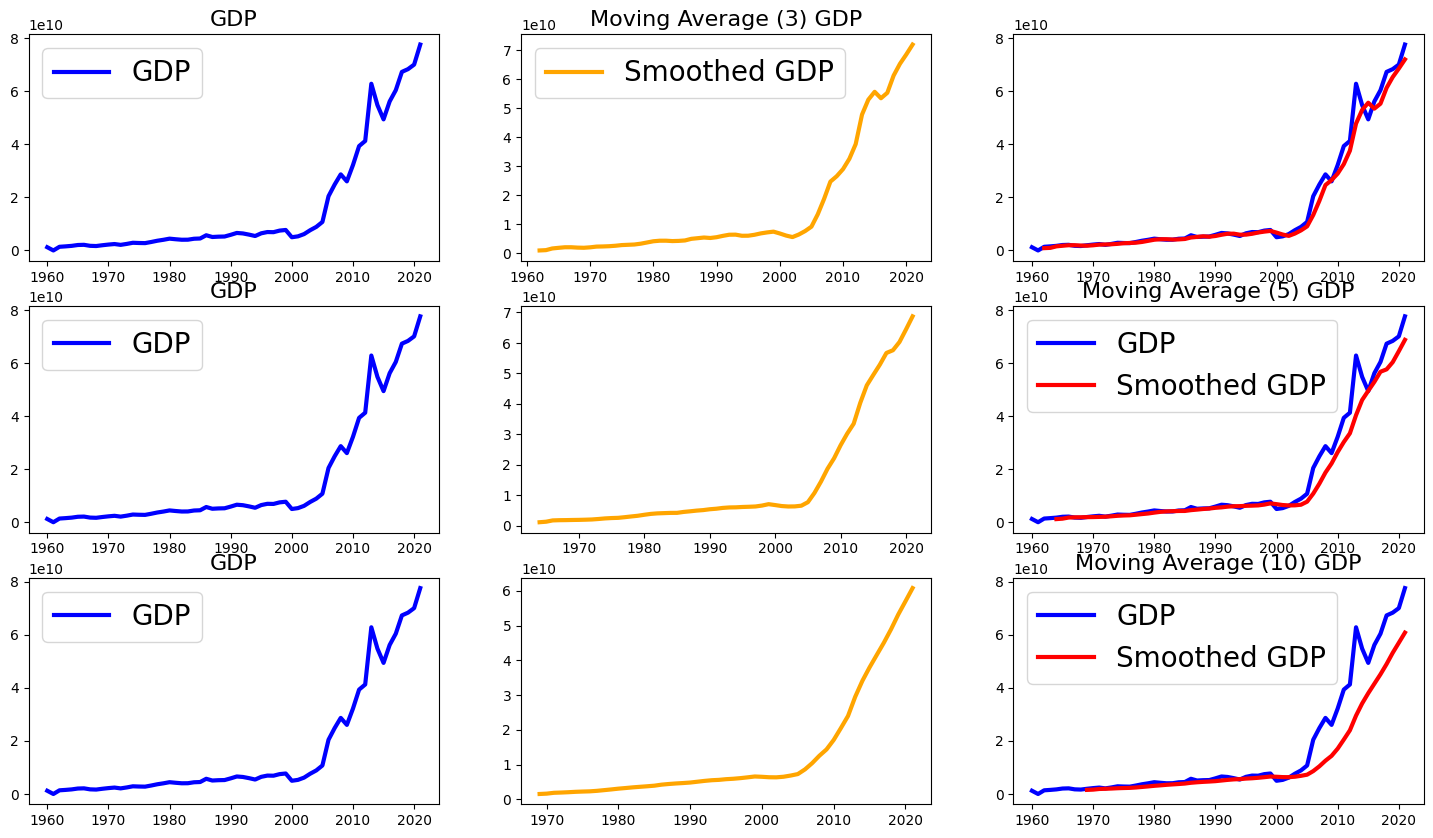

In [ ]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(3, 3)

# Окно в 3 года (Window = 3)
ax[0, 0].plot(data.GDP, color="blue", label="GDP")
ax[0, 0].set_title("GDP", size=16
)
ax[0, 0].legend()

ax[0, 1].plot(
    data.GDP.rolling(window=3).mean(),
    color="orange",
    label="Smoothed GDP",
)

ax[0, 2].plot(data, color="blue", label="GDP")
ax[0, 2].plot(
     data.GDP.rolling(window=3).mean(),
    color="red",
    label="Smoothed GDP",
)

ax[0, 1].set_title("Moving Average (3) GDP", size=16)
ax[0, 1].legend()

# Окно в десятилетие (Window = 5)
ax[1, 0].plot(data.GDP, color="blue", label="GDP")
ax[1, 0].set_title("GDP", size=16
)
ax[1, 0].legend()

ax[1, 1].plot(
    data.GDP.rolling(window=5).mean(),
    color="orange",
    label="Smoothed GDP",
)

ax[1, 2].plot(data, color="blue", label="GDP")
ax[1, 2].plot(
     data.GDP.rolling(window=5).mean(),
    color="red",
    label="Smoothed GDP",
)
ax[1, 2].set_title("Moving Average (5) GDP", size=16)
ax[1, 2].legend()


# Окно в десятилетие (Window = 10)
ax[2, 0].plot(data.GDP, color="blue", label="GDP")
ax[2, 0].set_title("GDP", size=16
)
ax[2, 0].legend()

ax[2, 1].plot(
    data.GDP.rolling(window=10).mean(),
    color="orange",
    label="Smoothed GDP",
)

ax[2, 2].plot(data, color="blue", label="GDP")
ax[2, 2].plot(
     data.GDP.rolling(window=10).mean(),
    color="red",
    label="Smoothed GDP",
)
ax[2, 2].set_title("Moving Average (10) GDP", size=16)
ax[2, 2].legend()

plt.show()


#### **Выводы:**
На графике виден постоянный рост показателя ВВП(Валового внутреннего продукта в пересчете на $ США).  
Начиная с 1960 г. тенденция резкого роста(возможно экпоненциального) показателя ВВП начиная с 2000 года.   
Т.к. экономика Ганы зависит от цен на полезные ископаемые, скорее всего это связано с ростом цен на них.  
В 2010 - 2015 годах заметен недолгий, но резкий спад.  
Посмотрим поподробнее на это место на графике

Спад ВВП с 2013 по 2015 год : 21.36%


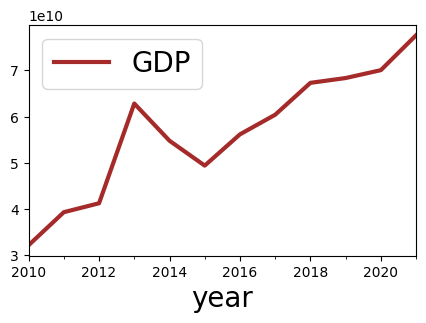

In [ ]:
data.loc['2010-01-01':].plot(figsize=(5, 3), color = 'brown')
print('Спад ВВП с 2013 по 2015 год : {:.2f}%'.format((1 - data.loc['2015-01-01','GDP']/data.loc['2013-01-01','GDP'])*100))

### **Выводы:**  
Действительно с 2013 по 2015 годы есть спад ВВП на 21,36%
Возможно, учитывая структуру экспорта, как основного источника ВВП это связано с  падением цен на золото в эти же годы почти на 24%(https://goldprice.org/gold-price-history.html), среднегодовая стоимость нефти упала в 2014 году на 45,55, в 2015 году на 30,53%(https://www.macrotrends.net/1369/crude-oil-price-history-chart , и хотя цены на какао в эти годы умеренно росли(https://tradingeconomics.com/commodity/cocoa), судя по всему это не смогло сдержать негативной тенденции.   
Эта тема безусловно требует более подробного изучения.

Продолжим наше исследование. В конечном итоге наша задача создать модель адекватно предсказывающую развитие данного показателя в будущем.
А для этого необходимо работать с временным рядом, обладающим свойством стационарности, т.е. по-простому отсутствия тренда и сезонности, при этом свойства ряда не изменяются во времени.

## Стационарность

С помощью теста Дики-Фуллера оценим стационарность временного ряда и примем решение о выборе модели ARMA/ARIMA.

In [ ]:
def stat_test(df):
    """Функция для определения стационарности временного ряда с помощью теста Дики-Фуллера

    Args:df (DataFrame,array): данные временного ряда
    """
    test = sm.tsa.adfuller(df) # определение статистик теста Дики-Фуллера
    print ('adf: ', test[0] ) #Test statistic
    print ('p-value: ', test[1]) #MacKinnon’s approximate p-value based on MacKinnon (1994, 2010)
    print('Critical values: ', test[4]) #Critical values for the test statistic at the 1 %, 5 %, and 10 % levels.
    if test[0]> test[4]['5%']:
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(train_df) #проводим тест на тренировочной выборке

adf:  0.6529066974885405
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
есть единичные корни, ряд не стационарен


Т.к. ряд нестационарен, используем дифференцирование ряда.

## Дифференцирование ряда
$y\_new_t = y_t - y_{t-1}$

where,
- $y\_new_t$: Дифференцированное значение ряда $t$
- $y_t$: Фактическое значение ряда $t$
- $y_{t-1}$: Фактическое значение ряда $t-1$

In [ ]:
#Начнем с дифференцирования со значением 1
otg1diff = train_df.diff(periods=1).dropna()

#проводим тест
stat_test(otg1diff)

adf:  -1.670248303832082
p-value:  0.44650293297138693
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
есть единичные корни, ряд не стационарен


In [ ]:
# т.к. ряд не стал стационарным, изучим ряд 2 порядка
otg2diff = otg1diff.diff(periods=1).dropna()
stat_test(otg2diff)

adf:  -2.6408690561284924
p-value:  0.08484116917837625
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
есть единичные корни, ряд не стационарен


In [ ]:
# может быть третий порядок приведёт к отсутствию единичных корней и выправится?
otg3diff = otg2diff.diff(periods=1).dropna()
stat_test(otg3diff)

adf:  -4.779623784828569
p-value:  5.948327640223947e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
единичных корней нет, ряд стационарен


Прекрасно, значит с этим рядом 3 порядка и будем работать дальше.

In [ ]:
# import statsmodels.graphics.tsaplots as sgt
def plot_acf_pacf(series, lags, alpha=0.05):
    """Функция для построения графиков автокорреляции и частичной корреляции(коррелограм)

    Args:
        series (DataFrame, array): стационарный временной ряд
        lags (_type_): количество предыдущих наблюдений для поиска схожести/зависимости
        alpha (float, optional): Доверительный интервал. Defaults to 0.05.
    """

    plt.rcParams["figure.figsize"] = 18, 5 #размеры графика
    fig, axes = plt.subplots(1, 2)
    sgt.plot_acf(series, ax=axes[0], lags=lags, alpha=alpha)#построение графика автокорреляции
    sgt.plot_pacf(series, ax=axes[1], lags=lags, method="ywm", alpha=alpha)#построение графика автокорреляции
    plt.show()

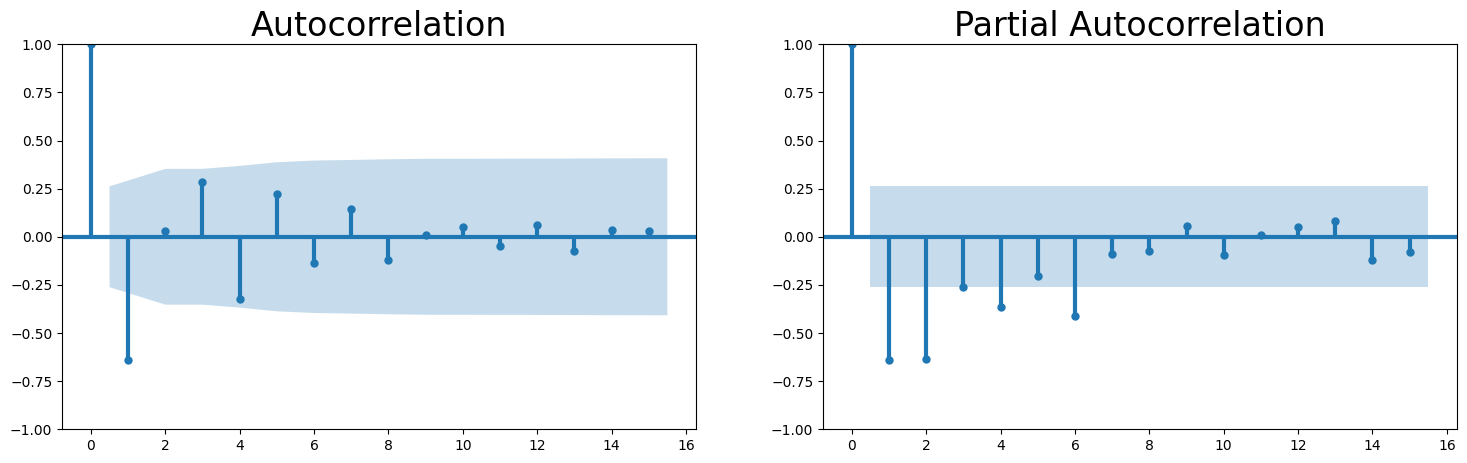

In [ ]:
plot_acf_pacf(otg3diff, 15)

На графике автокорреляции виден один явный лаг под номером 1, значит  ACF = 1, а вот на графике частичной корреляции непонятно, лаг номер 1 или 2 использовать.  
Это нам понадобится для построения модели временного ряда.
Для таких спорных случаев можно использовать старый-добрый перебор.  
Для этого есть специальный метод auto_arima из библиотеки pmdarima.   
Его и используем.


In [ ]:
# !pip install pmdarima
# import pmdarima as pm
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,#порядок дифференцирования
    start_q=1,
    max_p=3,
    max_q=3,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.06 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.03 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.05 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.10 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.08 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.23 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.07 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.69 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.16 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 2.120 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Fri, 14 Apr 2023   AIC                           2659.231
Time:                        12:24:31   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.17e+56. Standard errors may be unstable.
"""

Ну вот и определились параметры для построения модели ARIMA(2,3,1)

## ARIMA

Итак, что мы имеем: Временной ряд(размер ВВП Ганы) нестационарен, сезонности нет и нам нужен долгосрочный прогноз(> 1 шага).   
Следовательно, выбираем для прогноза модель **ARIMA**(интегрированное авторегрессионное скользящее среднее).  
Параметры модели подобраны в прошлом разделе:   
p(PACF)=2,  
d(порядок дифференцирования)=3,  
q(ACF)=1

In [ ]:
# from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(train_df["GDP"].dropna(), order=(2,3,1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Fri, 14 Apr 2023   AIC                           2659.231
Time:                        12:24:31   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.17e+56. Standard errors may be unstable.
"""

Второй столбец раздела I содержит некоторые полезные показатели, которые используются для сравнения различных моделей ARIMA. Как правило, модель с более высоким логарифмическим правдоподобием или более низким IC (AIC, BIC или HQIC) лучше, и наоборот.

Отобразим результат графически — построим графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

In [ ]:
pred_df = pd.DataFrame(index=data.index)#создадим базу данных для предсказания

pred_df["model_preds"] =arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
) #предскажем поведение показателя в тестовый период

pred_df["GDP"] = data["GDP"] #добавим фактические данные для сравнения

forecast =arima_model_fit.get_forecast(len(test_df.index)) #рассчитаем интервалы прогнозирования
forecast_df = forecast.conf_int(alpha=0.05)  #обозначим доверительный интервал прогнозирования в 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP"]#присвоим значения нижней границы доверительного интервала соответствующему индексу
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP"]#присвоим значения верхней границы доверительного интервала соответствующему индексу

In [ ]:
pred_df.tail()

,model_preds,GDP,model_preds_lower,model_preds_upper
year,,,,
2017-01-01,NaN,6.040638e+10,NaN,NaN
2018-01-01,NaN,6.729928e+10,NaN,NaN
2019-01-01,7.368591e+10,6.833754e+10,6.269386e+10,8.467796e+10
2020-01-01,7.954567e+10,7.004320e+10,6.163504e+10,9.745630e+10
2021-01-01,8.633936e+10,7.759428e+10,6.065904e+10,1.120197e+11


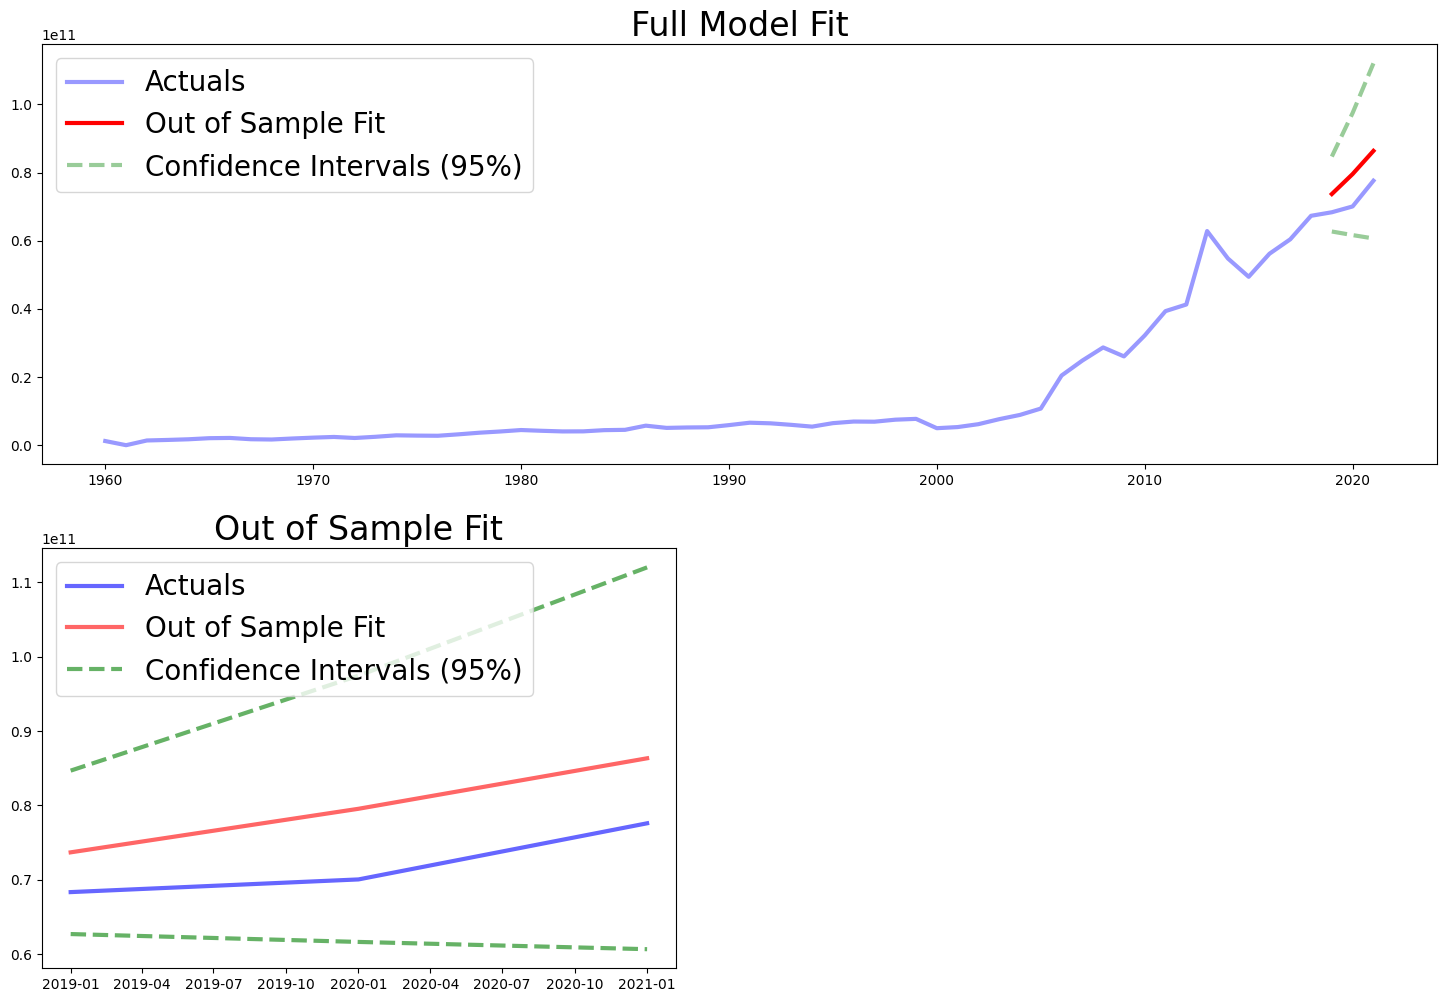

In [ ]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

In [ ]:
# from sklearn import metrics
#Средняя абсолютная ошибка прогноза:
mae = metrics.mean_absolute_error(pred_df['GDP'].loc["2019-01-01":], pred_df['model_preds'].loc["2019-01-01":])
#Средняя относительная ошибка прогноза:
mape = metrics.mean_absolute_percentage_error(pred_df['GDP'].loc["2019-01-01":], pred_df['model_preds'].loc["2019-01-01":])
print ('mape: {:.2f}%'.format(mape))
print ('mae: {:.0f}$'.format(mae))

mape: 0.11%
mae: 7865305751$


Из графика следует, что направление изменения величины ВВП Ганы предсказано верно, предсказание находится в середине доверительного интервала, относительная ошибка также невелика, хотя в абсолютных цифрах это \~79 млрд.$США
Также следует заметить, что график предсказаний как бы сдвинут вверх от фактических данных, возможно удастся избавиться от этого в дальнейшем, применив методы улавливающие изменение дисперсии во времени.

## Исследование с помощью интерполяции

Для начала проверим данные на наличие пропущенных дат с помощью ещё одного метода pandas.DataFrame.asfreq(), преобразующего данные к указанной частоте, передав в него, в нашем случае, параметр соответствующий году ('AS' или 'YS')

In [ ]:
data_as = data.asfreq(freq='AS')
data_as.sort_values(by = 'GDP').head(3)

,GDP
year,
1961-01-01,0.000000e+00
1960-01-01,1.217087e+09
1962-01-01,1.382353e+09


Данные соответствуют ранее полученным, т.е. на 1961 год нулевое значение.

Проверим данные также на наличие пропущенных значений

In [ ]:
data_as.astype(int).isna().sum()

GDP    0
dtype: int64

In [ ]:
# Для начала заменим пропуски на NaN
data_as['GDP'] = data_as['GDP'].apply(lambda x: np.nan if x==0 else x)
data_as.isna().sum()

GDP    1
dtype: int64

Для заполнения пропусков выполним интерполяцию с использованием линейной функции, т.к. визуальный анализ первой части графика изменения показателя ВВП позволяет предположить именно линейное изменение.

In [ ]:
interpolate_data = pd.DataFrame(data_as.resample('AS').interpolate(method='linear'))
interpolate_data.isna().sum()

GDP    0
dtype: int64

In [ ]:
interpolate_data.sort_values(by = 'GDP').head(3)

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09


У нас есть фактические даннные по ВВП Ганы за 1961 год(1,330000e+09) и мы можем сравнить их полученным в результате применённого метода интерполяции значения

In [ ]:
err = (interpolate_data.loc['1961-01-01']-1.330000e+09)/1.330000e+09*100
print ('Относительная ошибка при интерполяции с помощью линейной функции: {:.2f}%'.format(err['GDP']))

interpolate_data_poly = pd.DataFrame(data_as['GDP'].interpolate(method='polynomial', order = 2))
err_poly = (interpolate_data_poly.iloc[1]-1.330000e+09)/1.330000e+09*100
print ('Относительная ошибка при интерполяции с помощью полиномиальной функции(2 порядок): {:.2f}%'.format(err_poly['GDP']))

interpolate_data_poly = pd.DataFrame(data_as['GDP'].interpolate(method='polynomial', order = 3))
err_poly = (interpolate_data_poly.iloc[1]-1.330000e+09)/1.330000e+09*100
print ('Относительная ошибка при интерполяции с помощью полиномиальной функции(3 порядок): {:.2f}%'.format(err_poly['GDP']))

Относительная ошибка при интерполяции с помощью линейной функции: -2.28%
Относительная ошибка при интерполяции с помощью полиномиальной функции(2 порядок): -4.35%
Относительная ошибка при интерполяции с помощью полиномиальной функции(3 порядок): -5.61%


Несмотря на то, что график изменения показателя ВВП за весь период похож на график степенной функции, наилучшую интерполяцию даёт линейная функция.

<Axes: xlabel='year'>

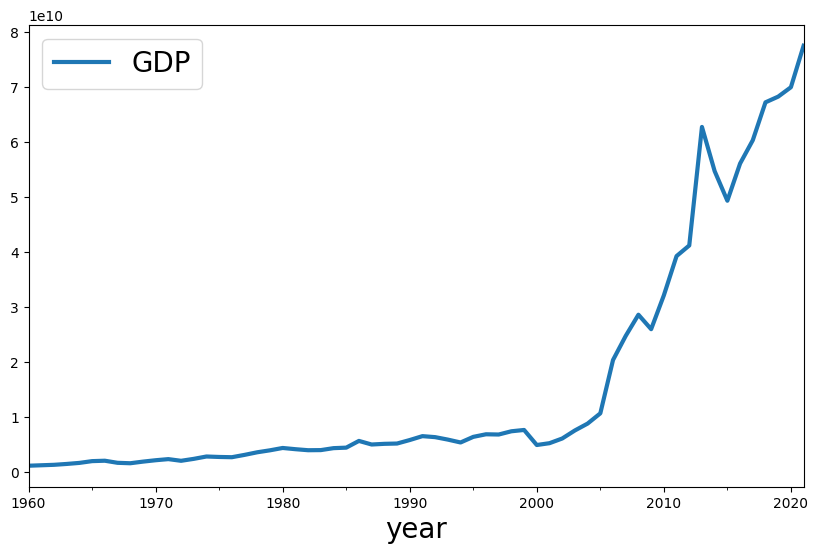

In [ ]:
interpolate_data.plot(figsize=(10, 6))

In [ ]:
#разделим выборку на тестовую и обучающую
train_df = interpolate_data.loc[:"2018-01-01"]
test_df = interpolate_data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

С помощью теста Дики-Фуллера оценим стационарность полученного временного ряда

In [ ]:
stat_test(train_df)

adf:  0.8030073326980115
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
есть единичные корни, ряд не стационарен


In [ ]:
otg1diff_interpol = train_df.diff(periods=1).dropna()
stat_test(otg1diff_interpol)

adf:  -1.8255652246436
p-value:  0.36784515276563423
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
есть единичные корни, ряд не стационарен


In [ ]:
otg2diff_interpol= otg1diff_interpol.diff(periods=1).dropna()
stat_test(otg2diff_interpol)

adf:  -2.63463474600784
p-value:  0.08604813722197724
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
есть единичные корни, ряд не стационарен


In [ ]:
otg3diff = otg2diff_interpol.diff(periods=1).dropna()
stat_test(otg3diff)

adf:  -4.825603687304043
p-value:  4.8573180767994686e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
единичных корней нет, ряд стационарен


Дифференцирование третьего порядка дало необходимый результат, ряд стал стационарным

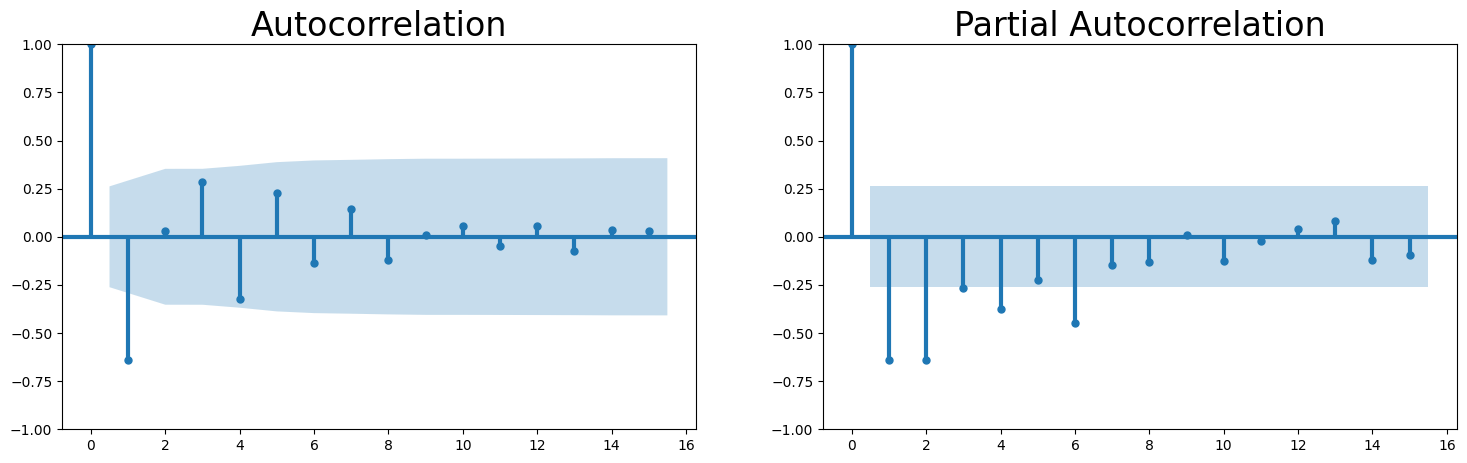

In [ ]:
# для определения показателей ACF и PACF построим кореллограммы
plot_acf_pacf(otg3diff, 15)

Применяем тест ARIMA, т.к. интерполированная база данных нестационарна и только инегрированный рад третьего порядка стационарен, сезонности нет и прогноз нужен не краткосрочный.
Однако визуально определить необходимые показатели ACF и PACF мне сложно, поэтому воспользуемся перебором, чтобы определить параметры модели ARIMA, показывающие более высокую метрику логарифмического правдоподобия или более низкое IC (AIC, BIC или HQIC)

In [ ]:
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,#порядок дифференцирования
    start_q=1,
    max_p=3,
    max_q=3,
    test="adf",
    error_action="ignore",
    trace=True
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.933, Time=0.22 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.778, Time=0.04 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.155, Time=0.02 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.372, Time=0.08 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.226, Time=0.20 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2678.992, Time=0.06 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.24 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.882, Time=0.09 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.72 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2665.990, Time=0.17 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 2.665 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.613
Date:                Fri, 14 Apr 2023   AIC                           2659.226
Time:                        12:24:38   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.29e+56. Standard errors may be unstable.
"""

Отобразим результат графически — построим графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

In [ ]:
arima_model = ARIMA(train_df["GDP"].dropna(), order=(2,3,1))
arima_model_fit = arima_model.fit()

In [ ]:
pred_df = pd.DataFrame(index=interpolate_data.index)

pred_df["model_preds"] =arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["GDP"] = interpolate_data["GDP"]

forecast =arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP"]

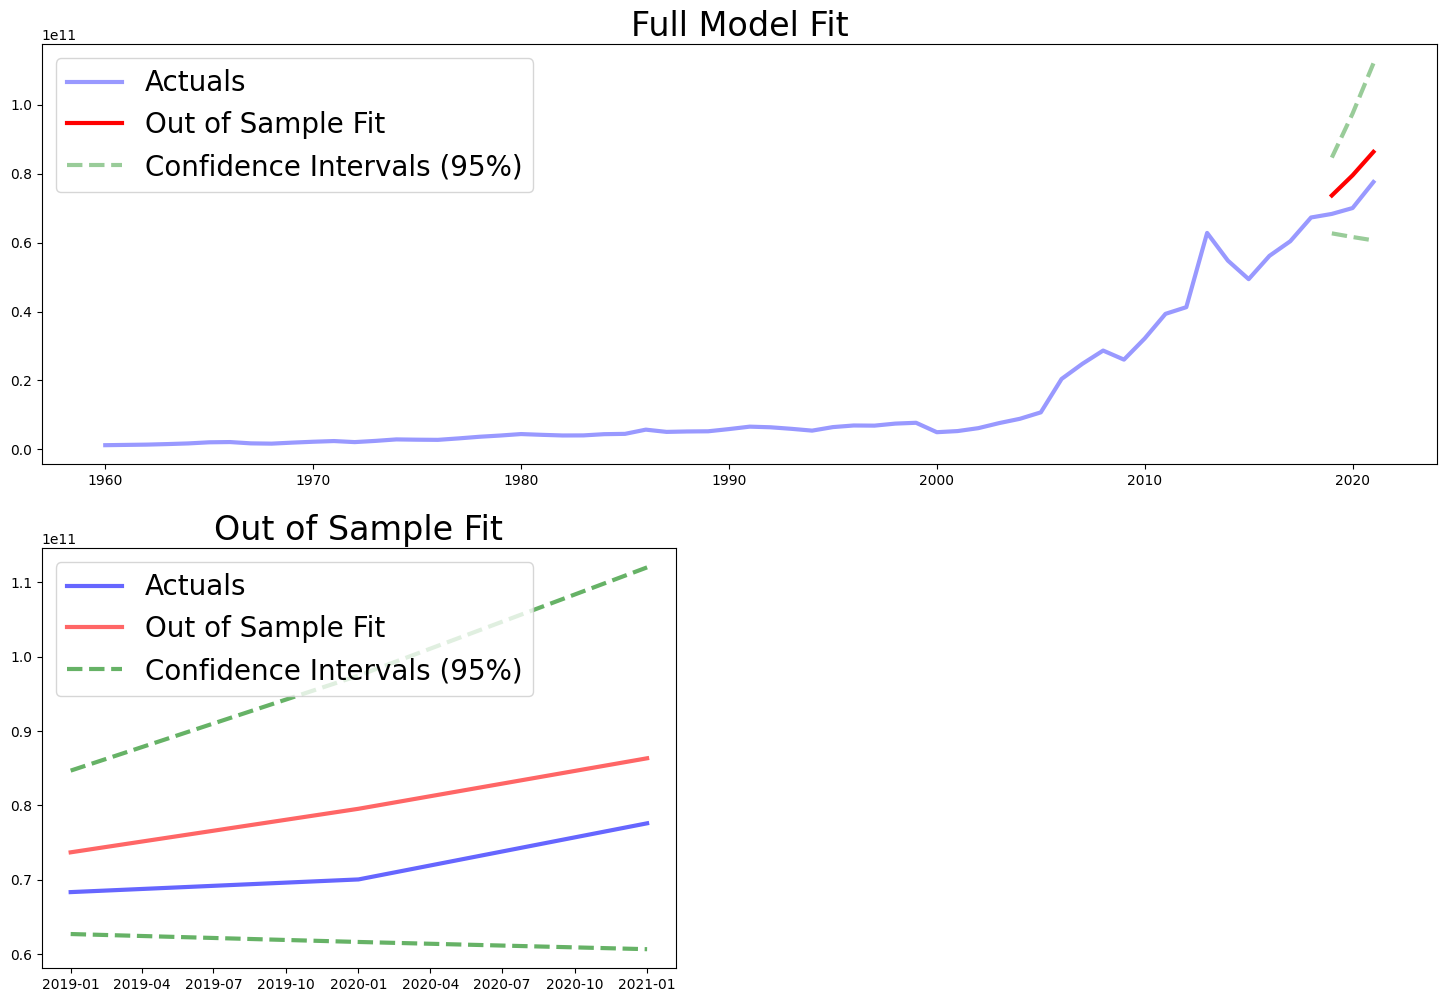

In [ ]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

Вывод по графику интерполиророванного графика аналогичен предыдущему

In [ ]:
#Средняя абсолютная ошибка прогноза:
mae = metrics.mean_absolute_error(pred_df['GDP'].loc["2019-01-01":], pred_df['model_preds'].loc["2019-01-01":])
#Средняя относительная ошибка прогноза:
mape = metrics.mean_absolute_percentage_error(pred_df['GDP'].loc["2019-01-01":], pred_df['model_preds'].loc["2019-01-01":])
print ('mape: {:.2f}%'.format(mape))
print ('mae: {:.0f}$'.format(mae))

mape: 0.11%
mae: 7869030582$


**Вывод:**
Метрику AIC на интерполированном ряду улучшить не удалось.
Остальное аналогично выводам по первоначальному временному ряду.
Из графика следует, что направление изменения величины ВВП Ганы предсказано верно, предсказание находится в середине доверительного интервала, относительная ошибка также невелика, хотя в абсолютных цифрах это \~79 млрд.$США
Также следует заметить, что график предсказаний как бы сдвинут вверх от фактических данных, возможно удастся избавиться от этого в дальнейшем, применив методы улавливающие изменение дисперсии во времени.  
К этому и перейдём. Проведём тест на гетероскедастичность, определим насколько однородно изменяется дисперсия во времени наблюдений за изменением ВВП Ганы.
  

# Тест на гетероскедастичность

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """Функция визуализирует временной ряд с авто- и частичной кореллограммами

    Args:
        y (DataFrame,array): временной ряд
        lags (int): Глубина предыдущих наблюдений для построения кореллограмм. Defaults to None.
        figsize (tuple): Размер графика. Defaults to (12, 7).
        style (str): Стиль построения графиков. Defaults to 'bmh'.
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return

Критерий Дики-Фуллера: p=0.377643


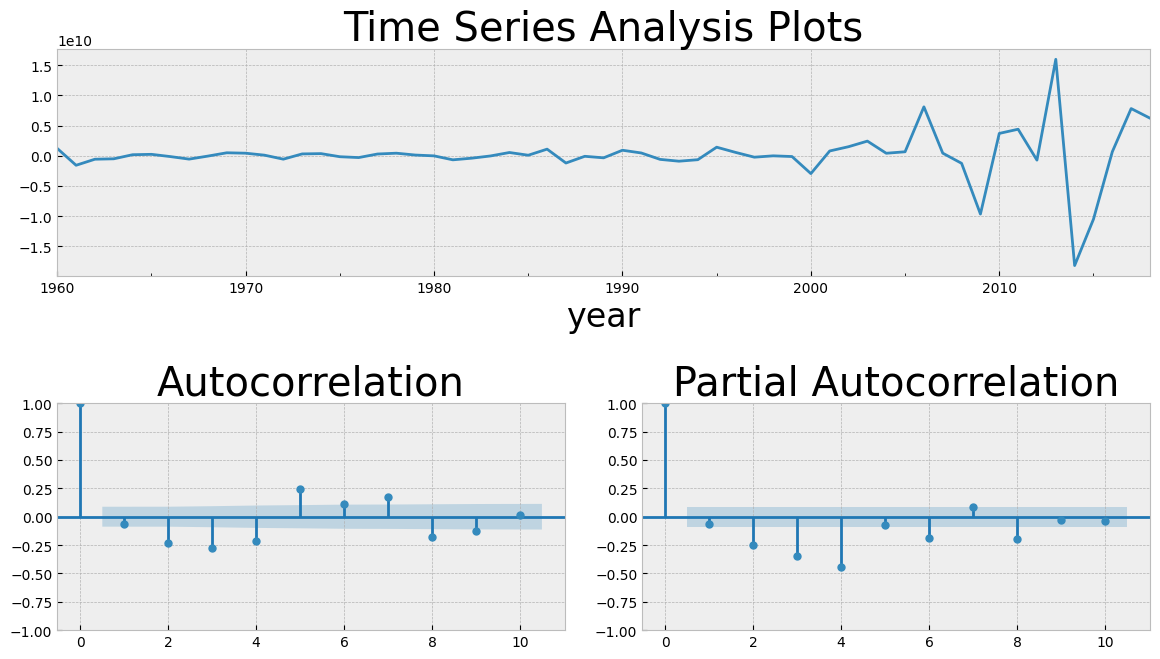

In [ ]:
#визуализируем остатки модели ARIMA на интерполированных данных
tsplot(arima_model_fit.resid, lags=10)

На графике видно, что разброс остатков увеличивается со временем. Это соответсвует определению гетероскедастичности, однако проведём ещё и тест Уайта на определение гетероскедастичности.

In [ ]:
# from statsmodels. stats.diagnostic import het_white
# import statsmodels.api as sm

#подготовим базу данных "объясняющих" переменных
b = train_df["GDP"].to_numpy ()
a = np.ones((59,1))
exog = np.column_stack((a, b))

#выполним тест Уайта
white_test = het_white(arima_model_fit.resid , exog )

#определим метки, которые будут использоваться для вывода теста Уайта
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

#выведем результаты теста Уайта
print(dict(zip(labels, white_test)))

{'Test Statistic': 24.585012313840267, 'Test Statistic p-value': 7.110260453127557e-07, 'F-Statistic': 40.71905283442707, 'F-Test p-value': 3.3918833780355034e-08}


**Выводы:**  
    Соответствующее значение p равно 0.000000711

В тесте Уайта используются следующие нулевая и альтернативная гипотезы:

    Null (H 0 ) : присутствует гомоскедастичность (остатки равномерно разбросаны)
    Альтернатива ( HA ): присутствует гетероскедастичность (остатки разбросаны неравномерно)

Поскольку p-значение меньше 0,05 мы  можем отвергнуть нулевую гипотезу.

Это означает, что у нас есть достаточные доказательства того, что в регрессионной модели присутствует гетероскедастичность.

## Исследование волатильности

Формула для расчёта волатильности  
 **Volatility** at time **t**  

$Vol(t) = |\frac{Price(t) - Price(t-1)}{Price(t-1)} * 100|$

In [ ]:
#посчитаем волатильность для нашего временного ряда.
# interpolate_data["GDP_vol"] = (interpolate_data.GDP - interpolate_data.GDP.shift(1))/interpolate_data.GDP.shift(1)
interpolate_data["GDP_vol"] = interpolate_data.GDP.pct_change(1).mul(100).abs()
interpolate_data.head()

,GDP,GDP_vol
year,,
1960-01-01,1.217087e+09,NaN
1961-01-01,1.299720e+09,6.789413
1962-01-01,1.382353e+09,6.357759
1963-01-01,1.540616e+09,11.448835
1964-01-01,1.731092e+09,12.363636


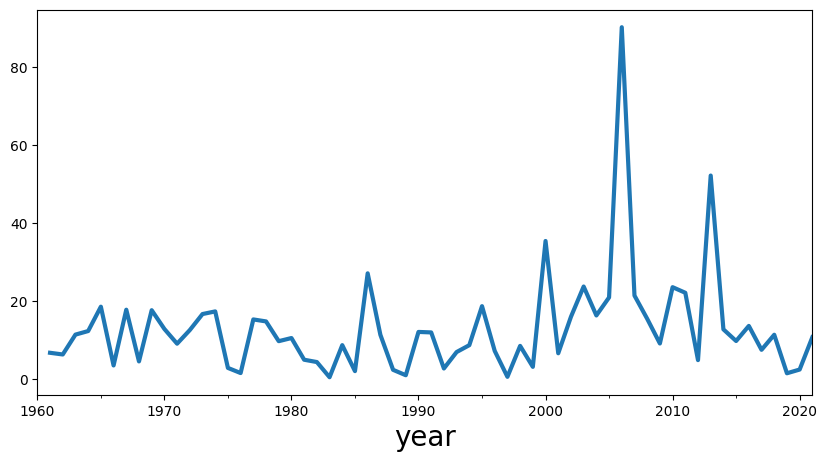

In [ ]:
#визуализируем волатильность
interpolate_data["GDP_vol"].plot(figsize = (10,5))
plt.show()

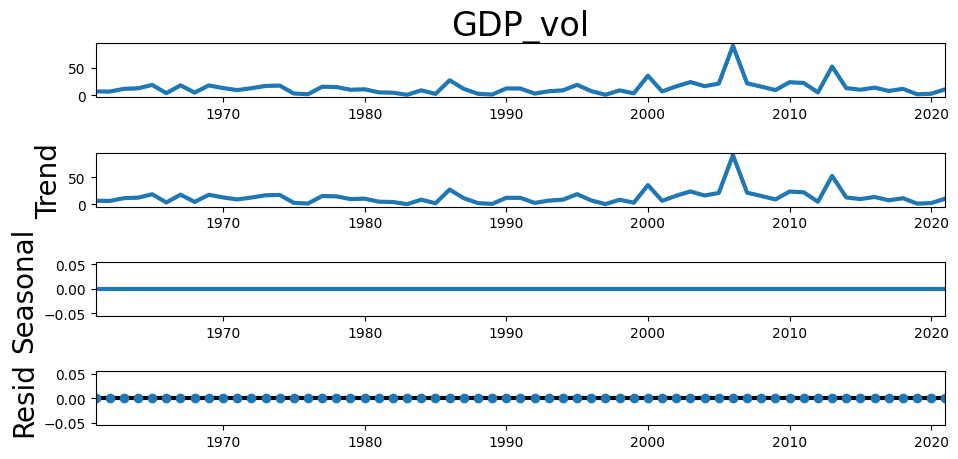

In [ ]:
# Построим график сезонной декомпозиции временного ряда

# from statsmodels.tsa.seasonal import seasonal_decompose
#для построения графика сезонной декомпозиции имортируем соответствующий метод
decomposition = seasonal_decompose(interpolate_data["GDP_vol"].dropna(), model='additive')
decomposition.plot()
pyplot.rcParams["figure.figsize"] = 5, 10
pyplot.show()

Выводы: Присутствует тренд, отсутствует сезонность, шум равномерно распределён в районе нуля.

In [ ]:
#разобъем выборку на 2 части тренировочную и тестовую
train_df = interpolate_data.loc[:"2018-12-31"]
test_df = interpolate_data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 2), (3, 2))

In [ ]:
#проверим временной ряд волатильности на стационарность
stat_test(train_df.GDP_vol[1:].dropna())

adf:  -6.725311059553779
p-value:  3.4014596148856493e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
единичных корней нет, ряд стационарен


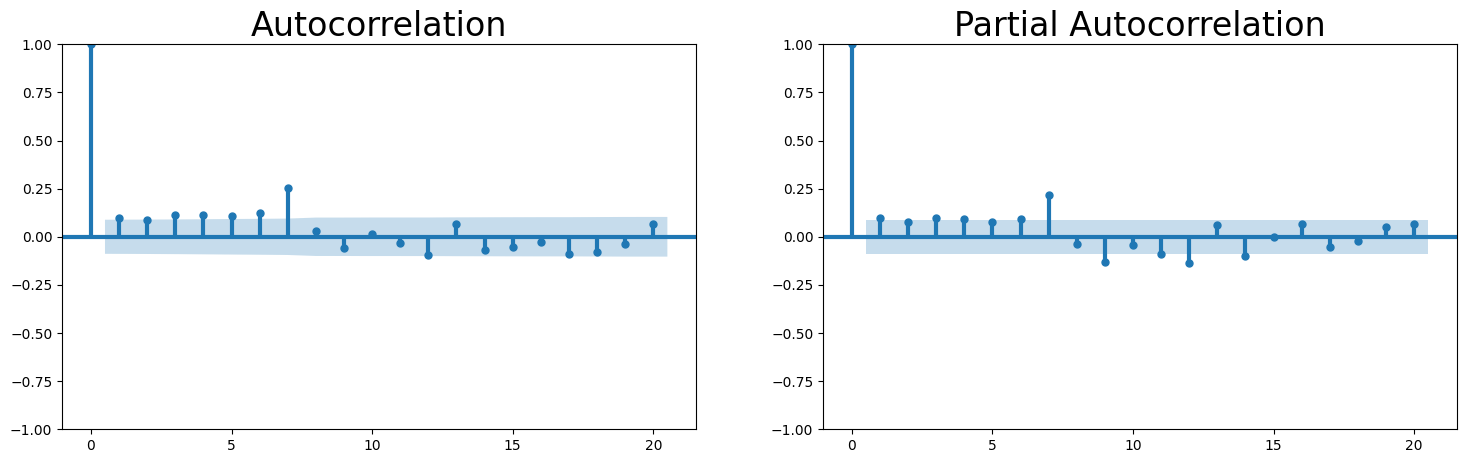

In [ ]:
#построим кореллограммы для определения параметров ACF и PACF для построения модели
plot_acf_pacf(train_df.GDP_vol[1:], 20, alpha = 0.5)

По графику определяем что ACF = 7 и PACF = 7

In [ ]:
# нам важно сохранить объем датасета, поэтому берем за исходные данные весь датасет с индексами, который содержит
# и train и test часть
garch_df = pd.DataFrame(interpolate_data["GDP_vol"].loc[data.index])

In [ ]:
# далее необходимо использовать актуальные обучающие данные, которые находятся в выборке train_df.
# Мы никак не преобразовывали нашу обучющую выборку, поэтому фактически, train_df совпадает с данными в data,
# Но если вы применяете к вашей обечающей выборке какие либо преобразования, например скользящее среднее
# для сглаживания, то необходимо передать измененный train_df датасет.

garch_df.loc[train_df.index, "GDP_vol"] = train_df["GDP_vol"].dropna()

In [ ]:
# !pip install arch
# from arch import arch_model
model = arch_model(garch_df["GDP_vol"].dropna(), p=7, q=7)

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

#model_results = model.fit(last_obs=test_df.index[0], update_freq=5)
model_results = model.fit(last_obs=test_df.index[0])

Iteration:      1,   Func. Count:     18,   Neg. LLF: 230.8741754137868
Iteration:      2,   Func. Count:     39,   Neg. LLF: 218.317793316974
Iteration:      3,   Func. Count:     56,   Neg. LLF: 216.0099645957221
Iteration:      4,   Func. Count:     73,   Neg. LLF: 221.1932170519167
Iteration:      5,   Func. Count:     91,   Neg. LLF: 234.38048115955718
Iteration:      6,   Func. Count:    110,   Neg. LLF: 216.30194736013175
Iteration:      7,   Func. Count:    128,   Neg. LLF: 214.87883991855102
Iteration:      8,   Func. Count:    145,   Neg. LLF: 214.7324411823871
Iteration:      9,   Func. Count:    162,   Neg. LLF: 214.61657781581928
Iteration:     10,   Func. Count:    179,   Neg. LLF: 214.61759052175603
Iteration:     11,   Func. Count:    197,   Neg. LLF: 214.60052710113294
Iteration:     12,   Func. Count:    214,   Neg. LLF: 214.58428354645787
Iteration:     13,   Func. Count:    231,   Neg. LLF: 214.5252416714761
Iteration:     14,   Func. Count:    248,   Neg. LLF: 214.

In [ ]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                GDP_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -214.008
Distribution:                  Normal   AIC:                           460.016
Method:            Maximum Likelihood   BIC:                           492.983
                                        No. Observations:                   58
Date:                Fri, Apr 14 2023   Df Residuals:                       57
Time:                        12:24:49   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.8666      1.572      7.550  4.349e-14 [  8.786, 14.947]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         44.1055     42.301      1.043      0.297    [-38.802,1.270e+02]
alpha[1]   3.2351e-08  7.767e-02  4.165e-07      1.000      [ -0.152,  0.152]
alpha[2]   7.8463e-08  2.299e-02  3.412e-06      1.000 [-4.507e-02,4.507e-02]
alpha[3]   6.5621e-14  6.853e-02  9.576e-13      1.000      [ -0.134,  0.134]
alpha[4]   3.6162e-03  1.492e-02      0.242      0.809 [-2.563e-02,3.286e-02]
alpha[5]   6.2496e-14  1.274e-02  4.906e-12      1.000 [-2.497e-02,2.497e-02]
alpha[6]       0.7319      0.915      0.800      0.424      [ -1.062,  2.525]
alpha[7]       0.1024      0.643      0.159      0.873      [ -1.157,  1.362]
beta[1]    5.7084e-07      0.501  1.139e-06      1.000      [ -0.982,  0.982]
beta[2]    3.6496e-07  6.190e-02  5.896e-06      1.000      [ -0.121,  0.121]
beta[3]    3.4349e-07  2.869e-02  1.197e-05      1.000 [-5.624e-02,5.624e-02]
beta[4]    3.0295e-07  9.122e-02  3.321e-06      1.000      [ -0.179,  0.179]
beta[5]    1.7888e-05  5.268e-02  3.396e-04      1.000      [ -0.103,  0.103]
beta[6]    3.6179e-07  3.014e-02  1.200e-05      1.000 [-5.908e-02,5.908e-02]
beta[7]    2.9083e-07      1.155  2.517e-07      1.000      [ -2.265,  2.265]
=============================================================================

Covariance estimator: robust
"""

In [ ]:
#предскажем волатильность для тестового периода
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

In [ ]:
predictions_df

,GDP,GDP_vol,Predictions
year,,,
2019-01-01,6.833754e+10,1.542746,211.494335
2020-01-01,7.004320e+10,2.495937,47.349117
2021-01-01,7.759428e+10,10.780603,46.946466


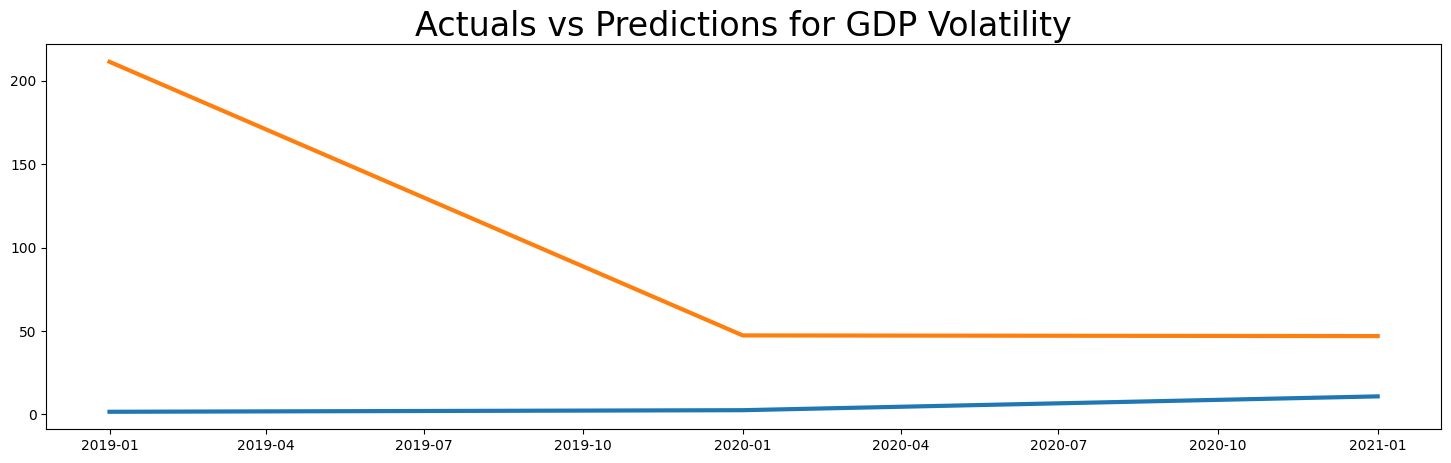

In [ ]:
# визуализируем  полученный результат
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["GDP_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for GDP Volatility", size=24)

plt.show()


Модель достаточно плохо предсказала волатильность, т.к. возможно в предыдущие периоды не было такой же динамики, какая присутсвует в тестовой выборке.

In [ ]:
# from sklearn.metrics import mean_squared_error
# определим среднеквадратичную ошибку для сравнения моделей
mean_squared_error(
    predictions_df["GDP_vol"].abs(), predictions_df["Predictions"]
)

15799.81566534356

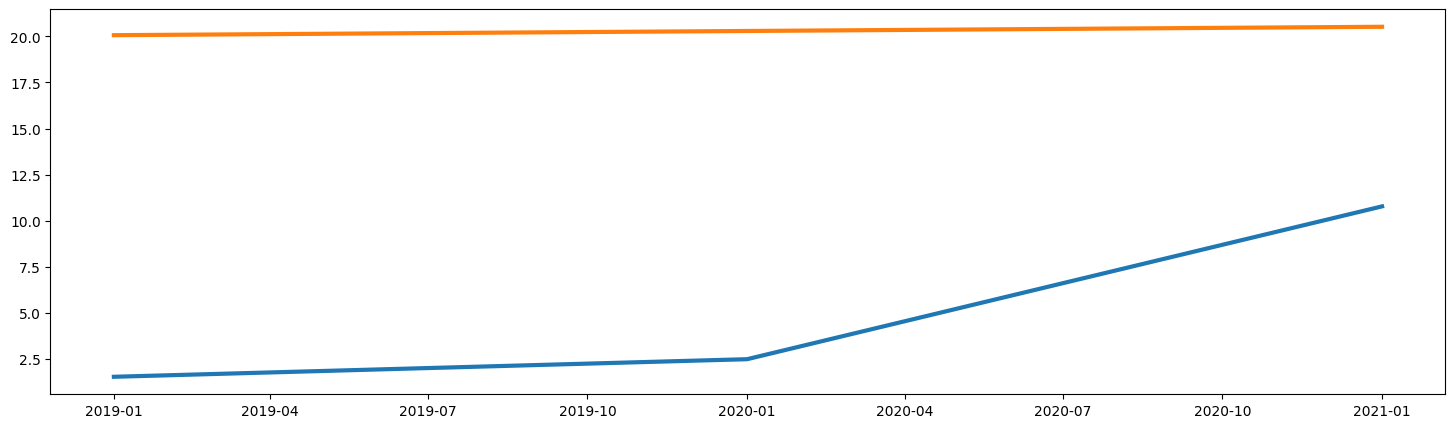

In [ ]:
# from sklearn.linear_model import LinearRegression
#  для сравнения построим модель линейной регрессии для предсказания волатильности
X_train = pd.DataFrame(range(interpolate_data["GDP_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(interpolate_data["GDP_vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["GDP_vol"].fillna(0)
y_test = test_df["GDP_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

In [ ]:
mean_squared_error(
    predictions_df["GDP_vol"].abs(), lr_predict
)

251.4089377647131

In [ ]:
lr_predict

array([20.06032062, 20.28796027, 20.51559993])

Вывод: Простая модель линейной регрессии лучше справилась с предсказанием волатильности.  

Общий вывод по практической работе: Несмотря на неудачу в предсказании волатильности методом GARCH, модель ARIMA с достаточной точностью(99,89%) дала прогноз изменения показателя ВВП Ганы на 2019-2021 годы.